# Import Libraries

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import os
from tqdm import tqdm
from sklearn.utils import shuffle
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

2025-07-17 18:46:06.599788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752777966.621534    2022 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752777966.628248    2022 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the Dataset

In [2]:
path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [3]:
train_path = path + "/train"
test_path = path + "/test"
val_path = path + "/val"

In [4]:
class_names = ["NORMAL", "PNEUMONIA"]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


nb_classes = len(class_names)

IMAGE_SIZE = (128, 128)

class_names_label

{'NORMAL': 0, 'PNEUMONIA': 1}

In [5]:
def load_data():

    datasets = [train_path, test_path, val_path]
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()

Loading /kaggle/input/chest-xray-pneumonia/chest_xray/train


100%|██████████| 1341/1341 [00:21<00:00, 61.05it/s]


Loading /kaggle/input/chest-xray-pneumonia/chest_xray/test


100%|██████████| 234/234 [00:02<00:00, 88.07it/s]


Loading /kaggle/input/chest-xray-pneumonia/chest_xray/val


100%|██████████| 8/8 [00:00<00:00, 91.78it/s]


In [7]:
train_images = np.concatenate((train_images, val_images), axis=0)
train_labels = np.concatenate((train_labels, val_labels), axis=0)

# Count and Compare Images in Each Folder

In [8]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [9]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 5232
Number of testing examples: 624
Each image is of size: (128, 128)


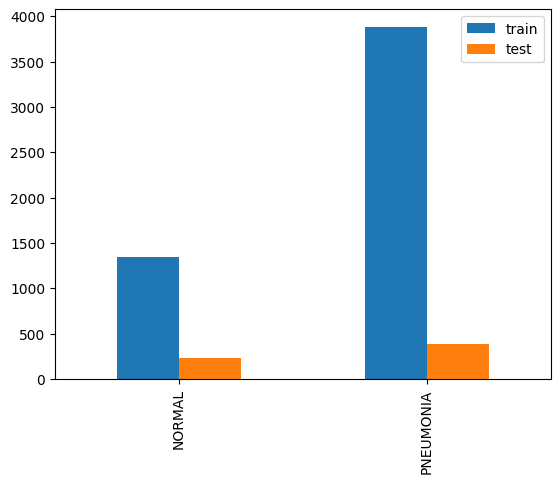

In [10]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

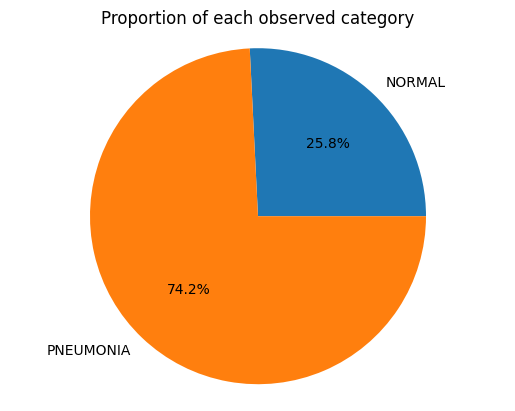

In [11]:
plt.pie(train_counts,
        explode=(0, 0) ,
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [12]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# Visualize the Dataset

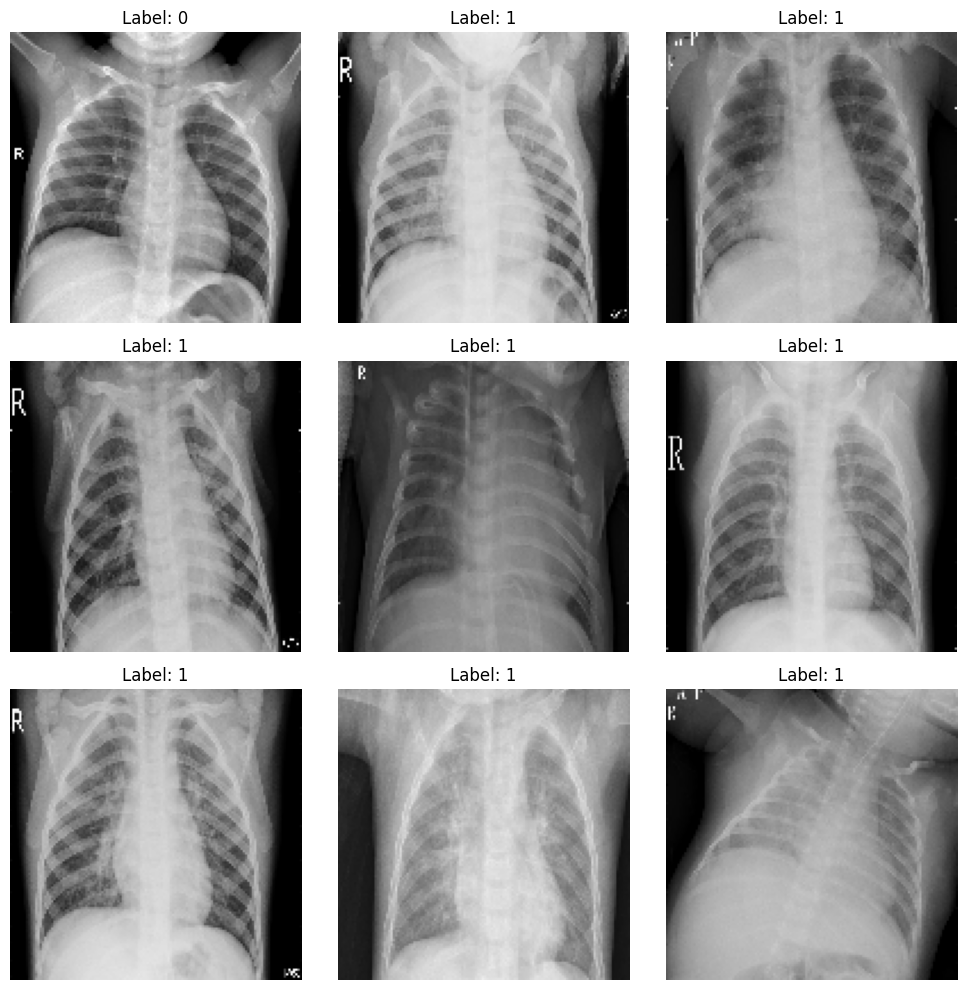

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        idx = np.random.randint(0, train_images.shape[0])
        img = train_images[idx]
        label = train_labels[idx]
        axs[i, j].imshow(img)
        axs[i, j].set_title(f'Label: {label}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

# Data Augmentation

In [14]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
train_generator = datagen.flow(
    train_images,
    train_labels,
    batch_size=32,
    shuffle=True,
    seed=42
)

# CNN model

In [33]:
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(4, 4),

    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(4, 4),

    Flatten(),
    Dense(64, activation='relu'),

    Dense(16, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,993 (660.13 KB)

 Trainable params: 168,545 (658.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [36]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [37]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

In [38]:
class_weights

{0: 1.939214232765011, 1: 0.6737058975019315}

In [39]:
history = model.fit(train_generator, epochs=20, validation_data=(test_images, test_labels), callbacks=[early_stop, reduce_lr] ,class_weight=class_weights)

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - accuracy: 0.7968 - loss: 0.4962 - val_accuracy: 0.6250 - val_loss: 3.3341 - learning_rate: 0.0010
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.8964 - loss: 0.2575 - val_accuracy: 0.6250 - val_loss: 3.8391 - learning_rate: 0.0010
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.8947 - loss: 0.2330 - val_accuracy: 0.7260 - val_loss: 1.1531 - learning_rate: 0.0010
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9255 - loss: 0.1907 - val_accuracy: 0.8670 - val_loss: 0.3405 - learning_rate: 0.0010
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.9347 - loss: 0.1734 - val_accuracy: 0.7917 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9321 - loss: 0.1911 - val_accuracy: 0.7756 - val_loss: 0.7918 - learning_rate: 0.0010
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.91

# Model Evaluation

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Test Accuracy: 0.9054

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.88      0.87       234
   PNEUMONIA       0.93      0.92      0.92       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



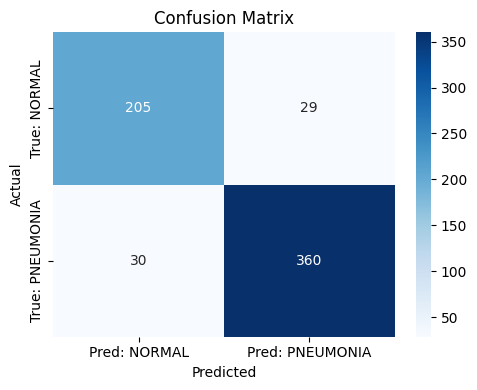

In [40]:
pred_probs = model.predict(test_images)

pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)
true_labels = np.array(test_labels)

# Accuracy score
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred: NORMAL", "Pred: PNEUMONIA"],
            yticklabels=["True: NORMAL", "True: PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
